# Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torchvision.models import alexnet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import argparse
from torch.utils.data import TensorDataset, DataLoader
from balanced_loss import Loss
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score


# Pre-Processing

### Real life Data Pre-Processing

We first import one training example and check its validity.

In [2]:
filepath = os.getcwd()+"/../../Real life data/Pre-processed/Images/EX_0000.npy.npz" # Import the data
array = np.load(filepath, allow_pickle=True)['arr_0'] # Load the data (compressed array so index the first one with ['arr_0'])

print(array[0:2]) # Check content

[[[[0.3372549  0.32156863 0.2627451  ... 0.35294118 0.29411765
    0.40392157]
   [0.35686275 0.29803922 0.40784314 ... 0.30588235 0.40784314
    0.36470588]
   [0.30196078 0.41176471 0.36862745 ... 0.43137255 0.40784314
    0.34117647]
   ...
   [0.55686275 0.41176471 0.63529412 ... 0.39607843 0.55686275
    0.51764706]
   [0.38039216 0.51764706 0.48235294 ... 0.45490196 0.41176471
    0.34117647]
   [0.2627451  0.27058824 0.21960784 ... 0.54509804 0.4
    0.62352941]]

  [[0.54901961 0.40392157 0.62745098 ... 0.40392157 0.58039216
    0.52941176]
   [0.38823529 0.54509804 0.50196078 ... 0.45098039 0.41176471
    0.3372549 ]
   [0.2627451  0.27058824 0.21960784 ... 0.5372549  0.39607843
    0.61960784]
   ...
   [0.10980392 0.12941176 0.13333333 ... 0.4        0.36470588
    0.29019608]
   [0.25490196 0.25490196 0.21568627 ... 0.70588235 0.54117647
    0.77254902]
   [0.70196078 0.53333333 0.76862745 ... 0.10588235 0.1372549
    0.14117647]]

  [[0.10588235 0.11764706 0.1254902  ... 0

In [3]:
print(array[0].shape) # Check shape of the first image

(3, 130, 130)


We will gather all the training examples stored in "Real life data/Pre-processed" and pre process them even further. Each training example after importation is an array consistsing of three elements: the square name (e.g., A1, C3), the image of the square, and the label of the piece placed on the square (if any). The label has a predefined encoding scheme which is the following:
- Empty: 0
- White pawn: 1
- White knight: 2
- White bishop: 3
- White rook: 4
- White queen: 5
- White king: 6
- Black pawn: 7 
- Black knight: 8
- Black bishop: 9
- Black rook: 10
- Black queen: 11
- Black king: 12

Since the square name column is not used in our model, we can discard it from each training example. We can separate the image data and label information by storing them in separate arrays, denoted by 'X_real_life' and 'y_real_life', respectively.

In [4]:
# Define the number of training examples
num_training_examples = 499
# Define empty array to store the data
X_real_life = np.empty((num_training_examples*64, 3, 130, 130))

# Loop through the data and store it in the array. We don't use np.concatenate or append to save computation time
for i in range (num_training_examples):
    X_real_life[i*64:(i+1)*64]= np.load(os.getcwd()+"/../../Real life data/Pre-processed/Images/EX_%04d.npy.npz" % i, allow_pickle=True)['arr_0'] # Load the data (compressed array so index the first one with ['arr_0'])

In [5]:
# Define empty array to store the labels
y_real_life = np.empty([num_training_examples*64])

# Loop through the data and store it in the array. We don't use np.concatenate or append to save computation time
for i in range (num_training_examples):
    y_real_life[i*64:(i+1)*64]= np.load(os.getcwd()+"/../../Real life data/Pre-processed/Labels/EX_%04d.npy" % i, allow_pickle=True) # Load the labels


Check the shape of X_real_life and y_real_life and plot the first image with its label as a verification step.

Shape of X array is: (31936, 3, 130, 130)
Shape of one training example is: (3, 130, 130)
Shape of the label is: (31936,)


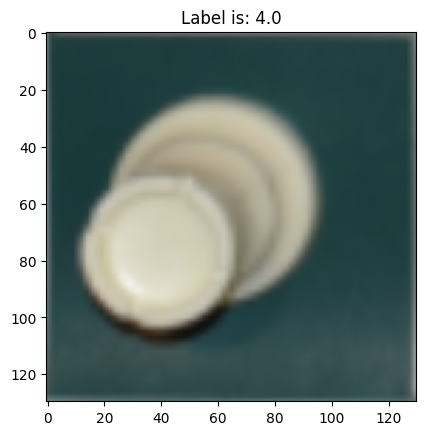

In [6]:
# Check the shape of the data
print("Shape of X array is:", X_real_life.shape)
# Check the shape of the 9th training exmaple
print("Shape of one training example is:", X_real_life[9*64].shape)
# Check the shape of the labels
print("Shape of the label is:", y_real_life.shape)

# Plot the image of the 9th training example at A1
plt.imshow(X_real_life[9*64].reshape([130, 130, 3]))
plt.title("Label is: "+str(y_real_life[0]))
plt.show()

We will now split the real-life dataset into training, validation and testing datasets. This will be done using the sklearn.train_test_split method. We then check the shapes of each set.

In [7]:
# split the dataset into train, validation, and test sets
X_real_life_train_val, X_real_life_test, y_real_life_train_val, y_real_life_test = train_test_split(X_real_life, y_real_life, test_size=0.3, random_state=0)
X_real_life_train, X_real_life_val, y_real_life_train, y_real_life_val = train_test_split(X_real_life_train_val, y_real_life_train_val, test_size=0.3/(0.4+0.3), random_state=0)

# Print shapes
print("X_real_life_train size is: ", X_real_life_train.shape)
print("y_real_life_train size is: ", y_real_life_train.shape)

print("X_real_life_val size is: ", X_real_life_val.shape)
print("y_real_life_val size is: ", y_real_life_val.shape)

print("X_real_life_test size is: ", X_real_life_test.shape)
print("y_real_life_test size is: ", y_real_life_test.shape)


X_real_life_train size is:  (12774, 3, 130, 130)
y_real_life_train size is:  (12774,)
X_real_life_val size is:  (9581, 3, 130, 130)
y_real_life_val size is:  (9581,)
X_real_life_test size is:  (9581, 3, 130, 130)
y_real_life_test size is:  (9581,)


Define the dataloaders: we need a dataloader for both the source (generated data) and the target (real-life data). Here we will create the dataloader for the real-life dataset in a method we will call later in the code.

In [8]:
def get_real_life_dataloader(batch_size, train=True):
    # create Tensor datasets
    train_data = TensorDataset(torch.Tensor(X_real_life_train), torch.Tensor(y_real_life_train))
    val_data = TensorDataset(torch.Tensor(X_real_life_val), torch.Tensor(y_real_life_val))
    test_data = TensorDataset(torch.Tensor(X_real_life_test), torch.Tensor(y_real_life_test))

    # create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=train)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=train)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=train)

    return train_loader, val_loader, test_loader

### Generated Data Pre-Processing

We first import one training example and check its validity.

In [9]:
filepath = os.getcwd()+"/../../Data Generation/Pre Processed Data Generated/Images/EX_0000.npy.npz" # Define the path to the data
array = np.load(filepath, allow_pickle=True)['arr_0'] # Load the data (compressed array so index the first one with ['arr_0'])
print(array[0:2]) # Check content

[[[[0.45098039 0.47843137 0.4745098  ... 0.38431373 0.37647059
    0.33333333]
   [0.38431373 0.37647059 0.33333333 ... 0.39607843 0.35686275
    0.4       ]
   [0.39607843 0.35686275 0.4        ... 0.4627451  0.49019608
    0.48627451]
   ...
   [0.61960784 0.56078431 0.64313725 ... 0.21960784 0.14509804
    0.22745098]
   [0.21960784 0.14901961 0.23137255 ... 0.4627451  0.49019608
    0.48235294]
   [0.31764706 0.36862745 0.36470588 ... 0.62352941 0.56470588
    0.64705882]]

  [[0.62745098 0.56862745 0.65098039 ... 0.21960784 0.14509804
    0.22745098]
   [0.21960784 0.14509804 0.22745098 ... 0.4627451  0.49019608
    0.48235294]
   [0.31764706 0.36862745 0.36470588 ... 0.63529412 0.57254902
    0.65882353]
   ...
   [0.45490196 0.38431373 0.41176471 ... 0.45490196 0.48627451
    0.48235294]
   [0.30980392 0.3254902  0.30980392 ... 0.70588235 0.63137255
    0.74117647]
   [0.70980392 0.62745098 0.74117647 ... 0.49019608 0.44313725
    0.45882353]]

  [[0.41568627 0.3372549  0.376470

In [10]:
print(array[0].shape) # Check shape of the first image

(3, 130, 130)


We will gather all the training examples stored in "Data Generated/ Dataset PreProcessed" and pre process them even further. Each training example after importation is an array consistsing of three elements: the square name (e.g., A1, C3), the image of the square, and the label of the piece placed on the square (if any). The label has a predefined encoding scheme which is the following:
- Empty: 0
- White pawn: 1
- White knight: 2
- White bishop: 3
- White rook: 4
- White queen: 5
- White king: 6
- Black pawn: 7 
- Black knight: 8
- Black bishop: 9
- Black rook: 10
- Black queen: 11
- Black king: 12

Since the square name column is not used in our model, we can discard it from each training example. We can separate the image data and label information by storing them in separate arrays, denoted by 'X_generated' and 'y_generated', respectively.

In [11]:
num_training_examples = 2000 # number of training examples
X_generated = np.empty([64*num_training_examples, 3, 130, 130]) # Create empty array to store the data

# Loop through the data and store it in the array. We don't use np.concatenate or append to save computation time
for i in range(num_training_examples):
    X_generated[i*64:(i+1)*64] = np.load(os.getcwd()+"/../../Data Generation/Pre Processed Data Generated/Images/EX_%04d.npy.npz" % i, allow_pickle=True)['arr_0'] # Load the data (compressed array so index the first one with ['arr_0'])

: 

: 

In [ ]:
y_generated = np.empty([64*num_training_examples]) # Create empty array to store the labels

# Loop through the labels and store it in the array. We don't use np.concatenate or append to save computation time
for i in range(num_training_examples):
    y_generated[i*64:(i+1)*64] = np.load(os.getcwd()+"/../../Data Generation/Pre Processed Data Generated/Labels/EX_%04d.npy" % i, allow_pickle=True) # Load the labels

Check the shape of X_generated and y_generated and plot the first image with its label as a verification step.

The shape of X is:  (44800, 3, 130, 130)
The shape of the first training example is: (3, 130, 130)
The shape of the labels is: (12800,)


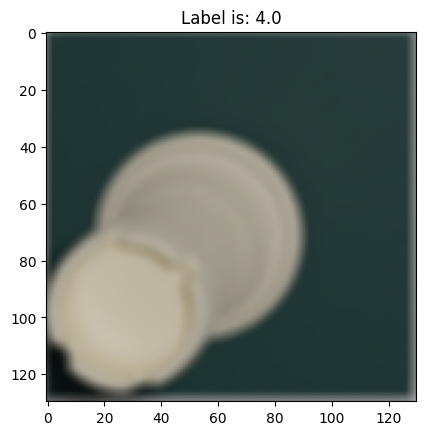

In [ ]:
print("The shape of X is: ", X_generated.shape)
print("The shape of the first training example is:", X_generated[0].shape)
print("The shape of the labels is:", y_generated.shape)

# Plot the image (A1 of EX_0000)
plt.imshow(X_generated[0].reshape([130, 130, 3]))
plt.title("Label is: "+str(y_generated[0]))
plt.show()

In [ ]:
# split the dataset into train, validation, and test sets
X_generated_train, X_generated_val, y_generated_train, y_generated_val = train_test_split(X_generated, y_generated, test_size=0.3, random_state=42)

print("X_generated_train size is: ", X_generated_train.shape)
print("y_generated_train size is: ", y_generated_train.shape)

print("X_generated_val size is: ", X_generated_val.shape)
print("y_generated_val size is: ", y_generated_val.shape)

ValueError: Found input variables with inconsistent numbers of samples: [44800, 12800]

Check the distributions of train and test sets.

In [ ]:
# create a dictionary that maps class numbers to their names
class_names = {0: 'Empty', 1: 'White pawn', 2: 'White knight', 3: 'White bishop', 4: 'White rook',
               5: 'White queen', 6: 'White king', 7: 'Black pawn', 8: 'Black knight', 9: 'Black bishop',
               10: 'Black rook', 11: 'Black queen', 12: 'Black king'}

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# plot the first histogram on the left subplot
hist, bins, _ = ax1.hist(y_generated_train, bins=range(14), align='left', rwidth=0.8)
ax1.set_xticks(list(class_names.keys()))
ax1.set_xticklabels(list(class_names.values()), rotation='vertical')
ax1.set_xlabel('Class')
ax1.set_ylabel('Frequency')
ax1.set_title('Data Distribution of the generated dataset')

# Store the count of each class in an array to define the losses later
samples_per_class_generated = hist

# add count number above each bar
for i in range(len(class_names)):
    ax1.text(i, (hist[i])+5, "{:.2f}%".format(int(hist[i]*100)/y_generated.shape[0]), ha='center')

# plot the second histogram on the right subplot
hist2, bins2, _ = ax2.hist(y_generated_val, bins=range(14), align='left', rwidth=0.8)
ax2.set_xticks(list(class_names.keys()))
ax2.set_xticklabels(list(class_names.values()), rotation='vertical')
ax2.set_xlabel('Class names')
ax2.set_ylabel('Frequency')
ax2.set_title('Data Distribution of the real life dataset')

# Store the count of each class in an array to define the losses later
samples_per_class_real_life = hist2

# add count number above each bar
for i in range(len(class_names)):
    ax2.text(i, (hist2[i])+5, "{:.2f}%".format(int(hist2[i])*100/y_real_life.shape[0]), ha='center')

# adjust the layout of the subplots
plt.subplots_adjust(wspace=0.5)

# show the plot
plt.show()

NameError: name 'plt' is not defined

Similarly as for the real-life dataset, we will generate the dataloaders for the generated dataset.

In [ ]:
def get_generated_dataloader(batch_size, train=True):
    # create Tensor datasets
    train_data = TensorDataset(torch.Tensor(X_generated_train), torch.Tensor(y_generated_train))
    val_data = TensorDataset(torch.Tensor(X_generated_val), torch.Tensor(y_generated_val))

    # create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=train)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=train)

    return train_loader, val_loader

In [ ]:
source_train_loader, source_validate_loader = get_generated_dataloader(batch_size=32, train=True)
target_train_loader, target_validate_loader, _ = get_real_life_dataloader(batch_size=32, train=True)

torch.save(source_train_loader, 'source_train_loader.pkl')
torch.save(source_validate_loader, 'source_validate_loader.pkl')
torch.save(target_train_loader, 'target_train_loader.pkl')
torch.save(target_validate_loader, 'target_validate_loader.pkl')

# Data Analysis

We will now plot the data distribution of both the real-life dataset and the generated dataset. We expect a lot of the data to be empty squares with label '0' in both dataset. We want to check that the distribution of the chess pieces are similar in both datasets or not.

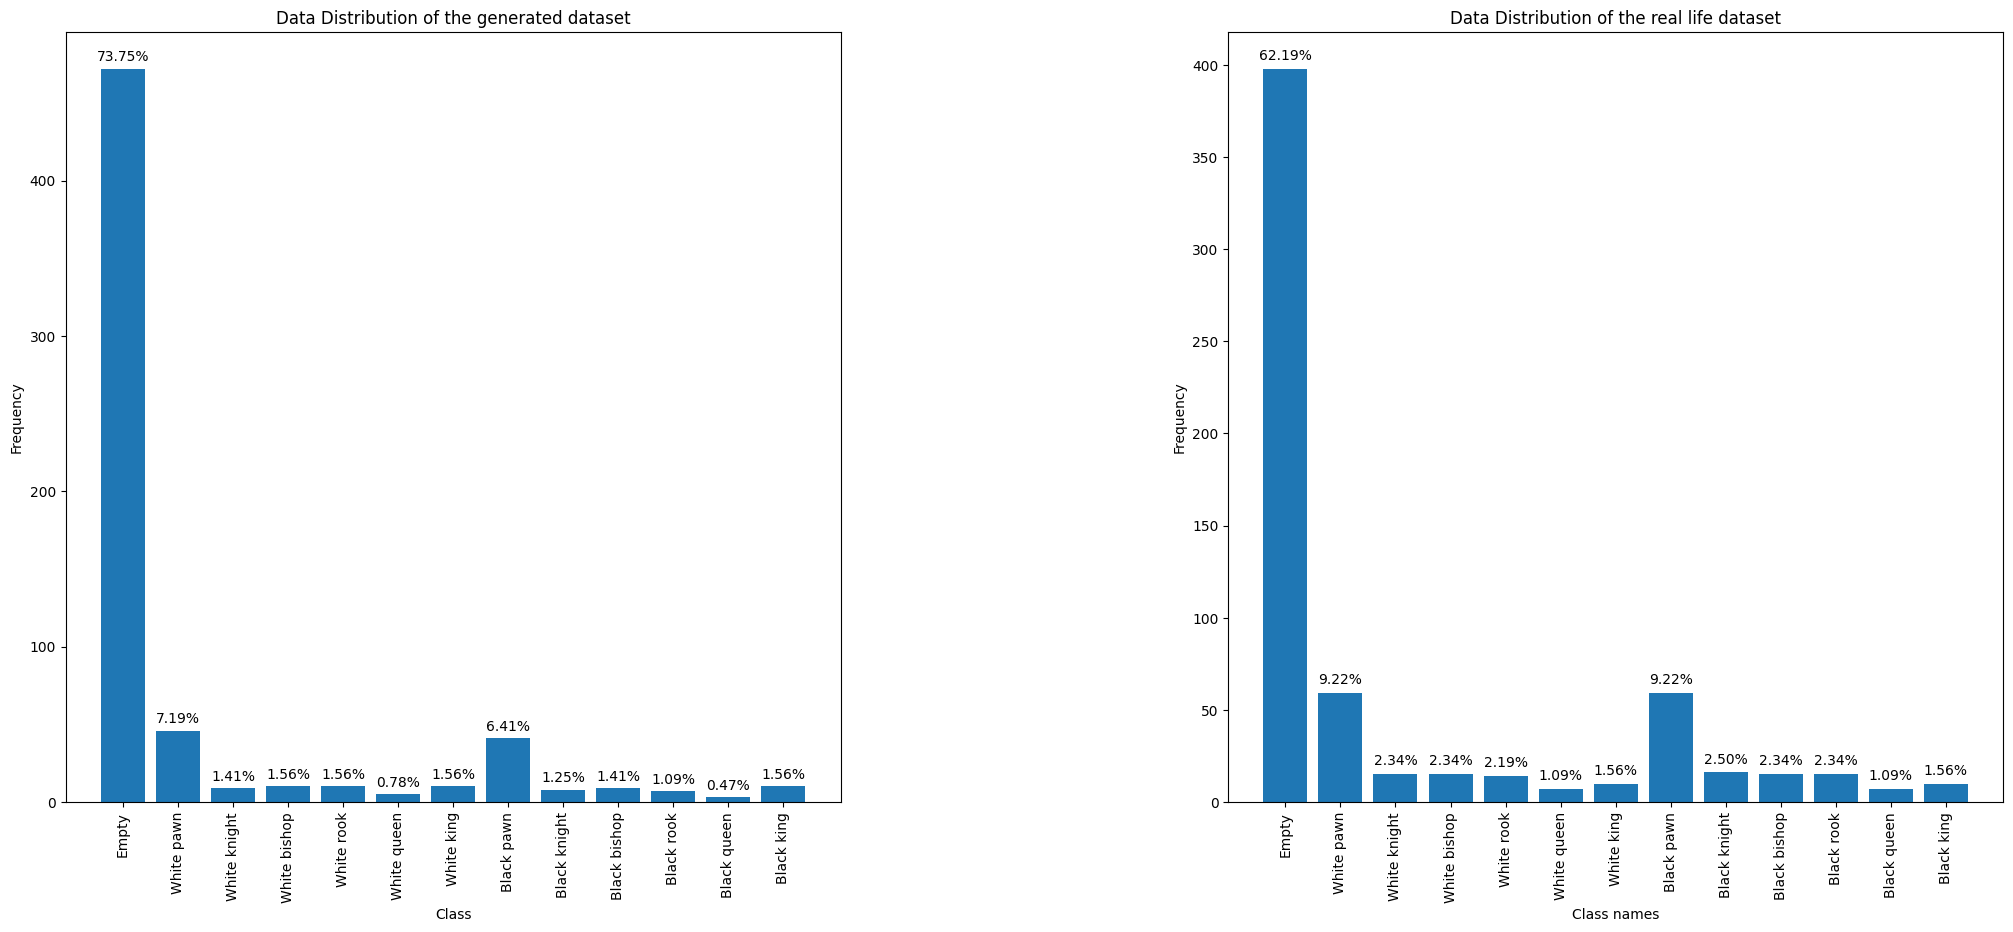

In [ ]:
# create a dictionary that maps class numbers to their names
class_names = {0: 'Empty', 1: 'White pawn', 2: 'White knight', 3: 'White bishop', 4: 'White rook',
               5: 'White queen', 6: 'White king', 7: 'Black pawn', 8: 'Black knight', 9: 'Black bishop',
               10: 'Black rook', 11: 'Black queen', 12: 'Black king'}

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# plot the first histogram on the left subplot
hist, bins, _ = ax1.hist(y_generated, bins=range(14), align='left', rwidth=0.8)
ax1.set_xticks(list(class_names.keys()))
ax1.set_xticklabels(list(class_names.values()), rotation='vertical')
ax1.set_xlabel('Class')
ax1.set_ylabel('Frequency')
ax1.set_title('Data Distribution of the generated dataset')

# Store the count of each class in an array to define the losses later
samples_per_class_generated = hist

# add count number above each bar
for i in range(len(class_names)):
    ax1.text(i, (hist[i])+5, "{:.2f}%".format(int(hist[i]*100)/y_generated.shape[0]), ha='center')

# plot the second histogram on the right subplot
hist2, bins2, _ = ax2.hist(y_real_life, bins=range(14), align='left', rwidth=0.8)
ax2.set_xticks(list(class_names.keys()))
ax2.set_xticklabels(list(class_names.values()), rotation='vertical')
ax2.set_xlabel('Class names')
ax2.set_ylabel('Frequency')
ax2.set_title('Data Distribution of the real life dataset')

# Store the count of each class in an array to define the losses later
samples_per_class_real_life = hist2

# add count number above each bar
for i in range(len(class_names)):
    ax2.text(i, (hist2[i])+5, "{:.2f}%".format(int(hist2[i])*100/y_real_life.shape[0]), ha='center')

# adjust the layout of the subplots
plt.subplots_adjust(wspace=0.5)

# show the plot
plt.show()

As anticipated, it is observed that there are numerous empty squares in both datasets. Additionally, the distribution of White and Black pawns in both datasets is remarkably similar. Moreover, the distribution of each class appears to be quite similar when comparing the two datasets. However, it is noted that the generated dataset has a greater number of empty square labels (76% compare to 70%).

# Model Implementation

We first define the Loss functions we will use when training our model. As previously demonstrated in the pre-processing section, the dataset is heavily imbalanced, with around 70% of training examples containing empty squares. In view of this, for the classification task, the class-balanced focal loss will be utilized, which effectively balances the loss across the sample classes. Utilization of this loss will result in improved evaluation of the model's loss. The equation defining this loss is as follows:

* First the effective number of samples are calculated for all classes as:

$$
E_{n} = \frac{1-\beta^{n}}{1-\beta}
$$

* Then the class balanced loss fucntion is defined as:

$$
L_{cb} (p,y) = \frac{1}E_{n_{y}}(-\frac{1}{N}\sum_{i=1}^{N}\alpha_{i}(1-p_{i})^{\gamma}\log(p_{i}))
$$

So we have:
$$
L_{cb} (p,y) = \frac{1-\beta}{1-\beta^{n_{y}}}(-\frac{1}{N}\sum_{i=1}^{N}\alpha_{i}(1-p_{i})^{\gamma}\log(p_{i}))
$$

This loss function is already implemented in the "Loss" package in balanced_loss which we imported. We need to specify the number of examples for each class. 

We also define the coral loss along with a helper function computing covariance. Coral loss is a type of distance metric used to align two sets of feature representations. It stands for "correlation alignment".

The Coral loss aims to minimize the domain shift between two distributions by aligning the second-order statistics of their features. It computes the covariance matrix of the source and target features and then minimizes the Frobenius norm between the difference of the two covariance matrices. This way, the correlation between the features is preserved and domain shift is reduced.

The Coral loss can be formulated as:

$$
L_{coral}(X_s, X_t) = \frac{1}{4d^2}\lVert C_s - C_t \rVert_{F}^2
$$

where $X_s$ and $X_t$ are the source and target feature representations respectively, $d$ is the number of features in each representation, and $C_s$ and $C_t$ are the covariance matrices of the source and target features.

In addition to the loss function, a helper function can be defined to compute the covariance matrix:

$$
C(X) = \frac{1}{n-1}(X-\bar{X})^T(X-\bar{X})
$$

where $X$ is a matrix of feature representations and $\bar{X}$ is the mean of each feature. The covariance matrix $C(X)$ can then be computed using the formula above.

In [ ]:
class DomainAdaptationModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(DomainAdaptationModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(128 * (input_shape[1] // 8) * (input_shape[2] // 8), 64),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(64, num_classes)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features
    
def coral_loss(source_features, target_features):
    source_cov = torch.matmul(source_features.T, source_features)
    target_cov = torch.matmul(target_features.T, target_features)
    loss = torch.mean(torch.square(source_cov - target_cov))
    return loss

# Define the class-balanced focal losses. 
# One for each dataset since they both have different number of samples per class
def class_balanced_focal_loss(logits, labels, source=True):
    if not source:
        focal_real_life_Loss = Loss(
            loss_type="focal_loss",
            samples_per_class=samples_per_class_real_life,
            class_balanced=True
        )
        return focal_real_life_Loss(logits, labels)
    else:
        focal_generated_Loss = Loss(
            loss_type="focal_loss",
            samples_per_class=samples_per_class_generated,
            class_balanced=True
        )
        return focal_generated_Loss(logits, labels)
    
def get_true_and_pred(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for data, labels in data_loader:
            logits, _ = model(data)
            pred = torch.argmax(logits, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    return y_true, y_pred
            
def train(model, source_loader, target_loader, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    best_val_acc = 0
    
    train_errors = []
    val_errors = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_domain_loss = 0
        total_classification_loss = 0
        num_batches = min(len(source_loader), len(target_loader))
        
        model.train()
        for i, ((source_data, source_labels), (target_data, _)) in enumerate(zip(source_loader, target_loader)):
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device) 

            # Forward pass for source data
            source_logits, source_features = model(source_data)
            source_classification_loss = nn.functional.cross_entropy(source_logits, source_labels.long())
            
            # Forward pass for target data
            target_logits, target_features = model(target_data)
            domain_loss = coral_loss(source_features, target_features)
            
            # Backward and optimization steps
            total_loss = source_classification_loss + domain_loss
            total_classification_loss += source_classification_loss.item()
            total_domain_loss += domain_loss.item()
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            if i == num_batches - 1:
                train_error = total_classification_loss + total_domain_loss
                train_errors.append(train_error)
                y_true, y_pred = get_true_and_pred(model, source_loader)
                train_acc = balanced_accuracy_score(y_true, y_pred, )
                train_accs.append(train_acc)

                val_error, val_acc = evaluate(model, target_loader)
                val_errors.append(val_error)
                val_accs.append(val_acc)
                print("Epoch {} - Train Error: {:.4f} = Classification Loss ({:.4f}) + CORAL Loss ({:.4f}), Train Accuracy: {:.4f}, Validation Error: {:.4f}, Validation Accuracy: {:.4f}".format(
                    epoch, train_error, total_classification_loss, total_domain_loss, train_acc, val_error, val_acc))
                
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "model_{}_{}.pt".format(epoch, best_val_acc))
            
    return train_errors, val_errors, train_accs, val_accs
    
def evaluate(model, loader):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    total_loss = 0
    total_classification_loss = 0
    total_domain_loss = 0
    total_predictions = []
    total_labels = []
    
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(device), labels.to(device)
            logits, _ = model(data)
            classification_loss = nn.functional.cross_entropy(logits, labels.long())
            total_loss += classification_loss.item()
            total_classification_loss += classification_loss.item()
            predictions = torch.argmax(logits, dim=1)
            total_predictions += predictions.tolist()
            total_labels += labels.tolist()
            
    accuracy = balanced_accuracy_score(total_labels, total_predictions)
    error = total_classification_loss / len(loader)
    return error, accuracy

In [ ]:
import torchvision.transforms as transforms

# Set the hyperparameters
lr = 0.001
num_epochs = 50
lambda_coral = 0.1
batch_size = 32

best_target_accuracy = 0

model = DomainAdaptationModel(input_shape=(3, 130, 130), num_classes=len(class_names))

source_train_loader = torch.load( 'source_train_loader.pkl')
source_validate_loader = torch.load('source_validate_loader.pkl')
target_train_loader = torch.load('target_train_loader.pkl')
target_validate_loader = torch.load('target_validate_loader.pkl')

train_errors, val_errors, train_accs, val_accs = train(model, source_train_loader, target_train_loader, num_epochs, lr)


Epoch 0 - Train Error: 322.8792 = Classification Loss (18.4972) + CORAL Loss (304.3819), Train Accuracy: 0.0769, Validation Error: 2.5923, Validation Accuracy: 0.0769
Epoch 1 - Train Error: 20.0052 = Classification Loss (18.5462) + CORAL Loss (1.4590), Train Accuracy: 0.0788, Validation Error: 2.5588, Validation Accuracy: 0.0779
Epoch 2 - Train Error: 20.1836 = Classification Loss (20.0460) + CORAL Loss (0.1376), Train Accuracy: 0.0661, Validation Error: 2.3955, Validation Accuracy: 0.0505
Epoch 3 - Train Error: 22.5637 = Classification Loss (16.6036) + CORAL Loss (5.9601), Train Accuracy: 0.0769, Validation Error: 1.9470, Validation Accuracy: 0.0769


KeyboardInterrupt: 